## Perform Data Wrangling (cleaning, feature extraction and analysis) on raw datasets 
Data set was retrieved from an artificial pancreas.

Data set contains 40,000 rows and 55,000 rows.

Perform machine learning on processed data. 

Train a model to predict whether a person has had a meal or not.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
import math

InsulinData.csv contains the time when a person eats a meal, indicated by a manual entry record of Carb value.

CGMData.csv contains records of insulin level (mg/dL) in the body every 5 min of the day.

The goal is to retrieve two types of data from CGMData.csv:

* A MEAL data comprises of 2hr stretch of time that starts from recorded time of meal and extends to 2hr after

* A NO-MEAL data comprises of 2hr stretch of time that is not part of meal data. 

In [132]:
# read csv files
df = pd.read_csv('InsulinData.csv', low_memory=False)
df2 = pd.read_csv('CGMData.csv', low_memory=False)
    
# retrieve rows with carb value greater than 0 and less than 1000
grams = df.loc[(df['BWZ Carb Input (grams)'] <= 1000) 
                & (df['BWZ Carb Input (grams)'] > 0)]
    
# print(grams['BWZ Carb Input (grams)'])

# length of data
i = len(grams) - 1
    
# retrieve the times of meal data
outtime, carblist = [],[]
    
# start from the bottom of the file, iterate through every row
while i > 0:
    date_time0 = pd.to_datetime(grams.iloc[i - 1, 1] + ' ' + grams.iloc[i - 1, 2])
    date_time1 = pd.to_datetime(grams.iloc[i - 2, 1] + ' ' + grams.iloc[i - 2, 2])
    carb = grams.iloc[i - 1, 24]

    # there is no meal within 2 hours stretch of time
    if (date_time1 >= (date_time0 + timedelta(days=0, hours=2))):
        outtime.append(str(date_time0))
        carblist.append(carb)
    i = i - 1

maxcarb = max(carblist)
mincarb = min(carblist)

nobins = math.floor((maxcarb - mincarb) / 20)
binrange = (maxcarb - mincarb) / nobins 

# convert times to pd times
insulin_meal_times = pd.to_datetime(outtime)
cgm_meal_times = pd.to_datetime((df2['Date'] + ' ' + df2['Time']).tolist())

In [133]:
print('Times of meal obtained from Insulin csv file \n', insulin_meal_times)

Times of meal obtained from Insulin csv file 
 DatetimeIndex(['2017-07-25 10:39:46', '2017-07-25 18:31:40',
               '2017-07-26 12:48:41', '2017-07-26 19:15:06',
               '2017-07-27 05:45:51', '2017-07-27 09:19:41',
               '2017-07-27 13:56:49', '2017-07-27 18:58:04',
               '2017-07-28 08:49:55', '2017-07-28 15:16:56',
               ...
               '2018-02-08 22:24:34', '2018-02-09 10:21:46',
               '2018-02-09 15:07:13', '2018-02-10 14:48:11',
               '2018-02-10 19:46:28', '2018-02-11 10:02:19',
               '2018-02-11 12:43:23', '2018-02-11 18:14:37',
               '2018-02-11 20:33:18', '2018-02-12 02:30:55'],
              dtype='datetime64[ns]', length=603, freq=None)


In [4]:
print('Get all times from CGM csv file \n', cgm_meal_times)

Get all times from CGM csv file 
 DatetimeIndex(['2018-02-12 13:22:27', '2018-02-12 13:17:27',
               '2018-02-12 13:12:27', '2018-02-12 13:07:27',
               '2018-02-12 13:02:27', '2018-02-12 12:57:27',
               '2018-02-12 12:52:27', '2018-02-12 12:47:27',
               '2018-02-12 12:42:27', '2018-02-12 12:37:27',
               ...
               '2017-07-25 12:53:54', '2017-07-25 12:48:54',
               '2017-07-25 12:43:54', '2017-07-25 12:38:54',
               '2017-07-25 12:33:54', '2017-07-25 12:28:54',
               '2017-07-25 12:23:54', '2017-07-25 12:18:54',
               '2017-07-25 12:13:54', '2017-07-25 12:08:54'],
              dtype='datetime64[ns]', length=55343, freq=None)


In [5]:
# get Sensor Glucose (mg/dL) values from CGM files
meal_df = pd.DataFrame(columns=range(1,25))
nomeal_df = pd.DataFrame(columns=range(1,25))
    
x, y = 0, 0
while x < len(insulin_meal_times):
    # GET MEAL DATA
    # get rows from cgm data within 2 hours stretch of time
    meal_row = df2.loc[(cgm_meal_times >= (insulin_meal_times[x])) &
            (cgm_meal_times <= (insulin_meal_times[x]) + timedelta(hours=2))]
        
    # get sensor glucose values only
    meal_value = meal_row['Sensor Glucose (mg/dL)'].tolist()
        
    # clean data, only 2 hours stretch of time that has 24 values
    if (len(meal_value) == 24): 
        meal_df.loc[x] = meal_value
        
        
    # GET NO MEAL DATA
    # get rows from cgm data [ insulin time + 2 hours <= cgm no meal times <= next insulin time ]
    if (x < (len(insulin_meal_times) - 1)):
        nomeal_row = df2.loc[(cgm_meal_times >= (insulin_meal_times[x] + timedelta(hours=2))) &
            (cgm_meal_times <= (insulin_meal_times[x + 1]))]
        
    # get sensor glucose values only
    nomeal_value = nomeal_row['Sensor Glucose (mg/dL)'].tolist()
        
    # breakup no meal rows to pieces of 24 
    a, b = 0, 24
    length_nomeal = len(nomeal_value)
    while length_nomeal/24 >= 1:
        # append 24 values to dataframe
        nomeal_df.loc[y] = nomeal_value[a:b]
            # print(nomeal_df)
        a = a + 24
        b = b + 24
        
        length_nomeal = length_nomeal - 24
        y = y + 1   
            
    x = x + 1
            
# clean data, drop rows with nan
meal_df = meal_df.dropna().reset_index().drop('index', 1)
nomeal_df = nomeal_df.dropna().reset_index().drop('index', 1)
    
# reverse order of meal dataframe so the first meal is at index 0
meal_df = meal_df.iloc[:,::-1]
# reverse order of header
meal_df.columns = range(1,25)

In [6]:
meal_df.head()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,248.0,241.0,231.0,220.0,222.0,222.0,222.0,223.0,224.0,228.0,...,270.0,277.0,274.0,269.0,267.0,267.0,274.0,284.0,283.0,278.0
1,83.0,87.0,100.0,112.0,121.0,125.0,130.0,132.0,123.0,112.0,...,67.0,71.0,75.0,74.0,72.0,70.0,67.0,74.0,77.0,81.0
2,201.0,194.0,188.0,183.0,181.0,176.0,170.0,168.0,169.0,172.0,...,210.0,213.0,212.0,216.0,213.0,210.0,210.0,209.0,210.0,209.0
3,125.0,122.0,123.0,130.0,149.0,162.0,169.0,179.0,192.0,203.0,...,200.0,196.0,189.0,183.0,179.0,177.0,173.0,165.0,153.0,152.0
4,55.0,58.0,70.0,77.0,87.0,99.0,108.0,112.0,120.0,127.0,...,132.0,140.0,147.0,157.0,172.0,175.0,183.0,191.0,198.0,200.0


In [7]:
nomeal_df.head()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,102.0,81.0,71.0,63.0,59.0,58.0,54.0,51.0,48.0,47.0,...,45.0,50.0,57.0,64.0,71.0,75.0,81.0,86.0,81.0,71.0
1,63.0,58.0,59.0,62.0,65.0,70.0,73.0,77.0,82.0,85.0,...,106.0,109.0,113.0,120.0,129.0,134.0,145.0,160.0,174.0,186.0
2,255.0,259.0,268.0,281.0,292.0,304.0,315.0,323.0,334.0,342.0,...,368.0,362.0,350.0,339.0,327.0,324.0,326.0,328.0,326.0,327.0
3,321.0,318.0,316.0,316.0,300.0,289.0,288.0,276.0,260.0,249.0,...,200.0,199.0,200.0,199.0,197.0,197.0,197.0,198.0,198.0,195.0
4,192.0,192.0,191.0,193.0,196.0,196.0,194.0,193.0,193.0,192.0,...,184.0,188.0,192.0,192.0,190.0,185.0,185.0,187.0,185.0,184.0


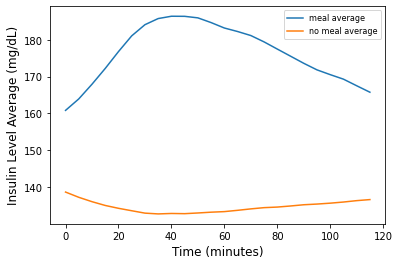

In [8]:
# VISUALIZE meal and no meal data
# average meal and no meal data based on time
x = meal_df.mean().tolist()
y = nomeal_df.mean().tolist()
    
# get time - idx * 5 minutes
z = []
for val in x: z.append(x.index(val)*5)
    
# line chart
    
# meal average from start of meal to end
plt.plot(z, x, label='meal average')

# no meal average over time
plt.plot(z, y, label='no meal average')

# labels
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Insulin Level Average (mg/dL)', fontsize=12)

# legend
plt.legend(loc="upper right", prop={'size': 8})

In [9]:
# extract features from cleaned data to efficiently train machine models
def prepare_data(data, string):
    
    # Take the difference in GLUCOSE between the highest maxValue and start of meal
    # Take the difference in TIME between the highest maxValue and start of meal
    
    # dataframe for feature extraction
    column = ['maxval', 'firstval', 'indexof_max', 'indexof_first', 'class']
    df = pd.DataFrame(columns=column)
 
    # Get max values of each row for both meal and nomeal data
    df['maxval'] = data.max(axis=1)

    # Get first value 
    df['firstval'] = data.iloc[:, 0]
    
    # get time difference, multiply by 5 minutes
    df['indexof_max'] = (data.idxmax(axis=1).astype('int64') - 24).abs() * 5
    df['indexof_first'] = 0
    
    # assign class
    if string=='meal_df' : 
         # meal time difference
        df['class'] = 1
        return df
    
    else: 
        # nomeal time difference
        df['class'] = 0
        return df

In [18]:
maxvalues_meal = prepare_data(meal_df, 'meal_df')
maxvalues_nomeal = prepare_data(nomeal_df, 'nomeal_df')
    
#print(maxvalues_meal)
    
# append two data
maxvalues_meal = maxvalues_meal.append(maxvalues_nomeal, ignore_index=True)

features = pd.DataFrame(columns=['feature1', 'feature2', 'class'])
features['feature1'] = (((maxvalues_meal['maxval'] - maxvalues_meal['firstval']) / maxvalues_meal['firstval']) + 1).round(3)
features['feature2'] = (maxvalues_meal['indexof_max'] - maxvalues_meal['indexof_first']).astype('int64') + 1
features['class'] = maxvalues_meal['class']

# train data
x_data = features[['feature1', 'feature2']]
y_data = features['class']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)
features

,feature1,feature2,class
0,1.145,11,1
1,1.590,81,1
2,1.075,31,1
3,1.704,56,1
4,3.636,1,1
...,...,...,...
1645,1.170,36,0
1646,1.009,111,0
1647,1.092,1,0
1648,5.519,1,0


In [11]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("Decision Tree")
print(classification_report(y_test, predictions))
#cross_val_score(clf, x_train, y_train, cv=10)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)
predictions1 = neigh.predict(x_test)
print("K Neighbors")
print(classification_report(y_test, predictions1))
#cross_val_score(neigh, x_train, y_train, cv=10)

random = RandomForestClassifier(random_state=0)
random.fit(x_train, y_train)
predictions3 = random.predict(x_test)
print("Random Forest Classifier")
print(classification_report(y_test, predictions3)) 

gradient = GradientBoostingClassifier(random_state=0)
gradient.fit(x_train, y_train)
predictions4 = gradient.predict(x_test)
print("Gradient Boosting Classifier")
print(classification_report(y_test, predictions4))   

Decision Tree
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       235
           1       0.54      0.44      0.49        95

    accuracy                           0.73       330
   macro avg       0.66      0.64      0.65       330
weighted avg       0.72      0.73      0.72       330

K Neighbors
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       235
           1       0.41      0.62      0.49        95

    accuracy                           0.63       330
   macro avg       0.61      0.63      0.60       330
weighted avg       0.69      0.63      0.65       330

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       235
           1       0.61      0.49      0.55        95

    accuracy                           0.76       330
   macro avg       0.71      0.68      0.69       330
weighted avg       0.75

### Training with extracted features data doesn't seem to yield satisfactory result, with the highest cross validation accuracy result of 80%. Let's see what training with (cleaned) raw data will produce 

In [12]:
# train with raw data
raw_meal = meal_df
raw_meal['class'] = 1
raw_meal.head()

raw_nomeal = nomeal_df
raw_nomeal['class'] = 0
raw_nomeal.head()

raw = raw_meal.append(raw_nomeal, ignore_index=True)

# train data
x_data1 = raw[range(1,25)]
y_data1 = raw['class']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data1, y_data1, test_size=0.2, shuffle=True)

In [13]:
clf1 = DecisionTreeClassifier(random_state=0)
clf1.fit(x_train1, y_train1)
predict0 = clf1.predict(x_test1)
print("Decision Tree")
print(classification_report(y_test1, predict0))
#cross_val_score(clf, x_train, y_train, cv=10)

neigh1 = KNeighborsClassifier(n_neighbors=3)
neigh1.fit(x_train1, y_train1)
predict1 = neigh1.predict(x_test1)
print("K Neighbors")
print(classification_report(y_test1, predict1))
#cross_val_score(neigh, x_train, y_train, cv=10)

random1 = RandomForestClassifier(random_state=0)
random1.fit(x_train1, y_train1)
predict3 = random1.predict(x_test1)
print("Random Forest Classifier")
print(classification_report(y_test1, predict3)) 

gradient1 = GradientBoostingClassifier(random_state=0)
gradient1.fit(x_train1, y_train1)
predict4 = gradient1.predict(x_test1)
print("Gradient Boosting Classifier")
print(classification_report(y_test1, predict4))    

Decision Tree
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       231
           1       0.55      0.47      0.51        99

    accuracy                           0.72       330
   macro avg       0.67      0.65      0.66       330
weighted avg       0.71      0.72      0.72       330

K Neighbors
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       231
           1       0.67      0.47      0.56        99

    accuracy                           0.77       330
   macro avg       0.74      0.69      0.70       330
weighted avg       0.76      0.77      0.76       330

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       231
           1       0.69      0.55      0.61        99

    accuracy                           0.79       330
   macro avg       0.76      0.72      0.73       330
weighted avg       0.78

#### Training with raw data only increases the accuracy result for K-Neighbors and Random Forest Classifier

### It's time to train data with Unsupervised learning methods


In [109]:
features2 = pd.DataFrame(columns=['feature1', 'feature2', 'feature3'])
features2['feature1'] = (((maxvalues_meal['maxval'] - maxvalues_meal['firstval']) / maxvalues_meal['firstval']) + 1).round(3)
features2['feature2'] = (maxvalues_meal['indexof_max'] - maxvalues_meal['indexof_first']).astype('int64') + 1
features2['feature3'] = ((maxvalues_meal['maxval'] - maxvalues_meal['firstval']))
    
scaler = MinMaxScaler()
features2 = scaler.fit_transform(features2)
features2 = pd.DataFrame(features2, columns=['feature1','feature2','feature3'])
features2

,feature1,feature2,feature3
0,0.023770,0.086957,0.118033
1,0.096721,0.695652,0.160656
2,0.012295,0.260870,0.049180
3,0.115410,0.478261,0.288525
4,0.432131,0.000000,0.475410
...,...,...,...
1645,0.027869,0.304348,0.052459
1646,0.001475,0.956522,0.003279
1647,0.015082,0.000000,0.022951
1648,0.740820,0.000000,0.770492


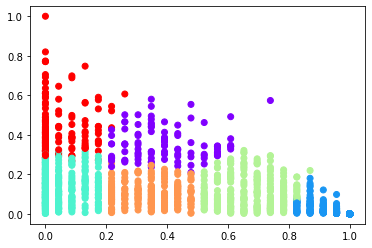

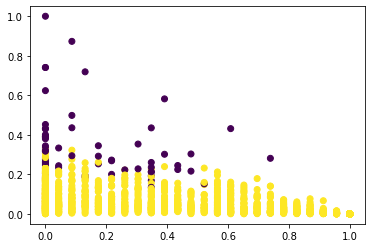

,dbscan,kmeans
0,0,2
1,0,3
2,0,4
3,0,0
4,-1,5
...,...,...
1645,0,4
1646,0,1
1647,0,2
1648,-1,5


In [140]:
kmeans = KMeans(n_clusters=nobins, n_init=10, max_iter=300, random_state=0).fit(features2)
dbscan = DBSCAN(eps=0.1, min_samples=20).fit(features2)

kmeanslabels = kmeans.labels_
dbscanlabels = dbscan.labels_

labels = pd.DataFrame(columns=['dbscan', 'kmeans'])
labels['dbscan'] = dbscanlabels
labels['kmeans'] = kmeanslabels


plt.scatter(features2['feature2'], features2['feature3'], c=kmeanslabels, cmap="rainbow")
plt.show()

plt.scatter(features2['feature2'], features2['feature1'], c=dbscanlabels)
plt.show()

labels

### Calculating accuracy of clustering using Sum of Squared.

In [141]:
# Calculate Sum-of-Square for K-means clustering
ksse = kmeans.inertia_
ksse

21.862698655770068

In [142]:
# Calculate Sum-of-Square for DBSCAN clustering
bins = pd.concat([features2, labels], axis=1)
i, sumsse = bins['dbscan'].min(),0
nocluster = bins['dbscan'].max()
nocluster
while i < nocluster:
    bincluster = bins.loc[bins['dbscan'] == i]
    f1mean = np.sum(bincluster['feature1'])/len(bincluster['feature1'])
    f2mean = np.sum(bincluster['feature2']) / len(bincluster['feature2'])
    f3mean = np.sum(bincluster['feature3']) / len(bincluster['feature3'])
    j=0
    while j< len(bincluster['feature1']):
        s = pow((bincluster.iloc[j,0]-f1mean),2)+pow((bincluster.iloc[j,1]-f2mean),2)+pow((bincluster.iloc[j,2]-f3mean),2)
        sumsse=sumsse+s
        j=j+1
    i = i + 1
sumsse

4.903362825869353

#### DBSCAN is the better method of clustering with out dataset with low number of SSE at 4.9